In [9]:
! pip install pandas
! pip install matplotlib
! pip install statsmodels
! pip install scikit-learn
! pip install openpyxl




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")


In [2]:
# Load the dataset
df = pd.read_excel("superstore_forecasting_dataset.xlsx")

# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Drop rows with non-positive sales
df = df[df['Sales'] > 0]

# Optional: drop NaNs in important columns
df = df.dropna(subset=['Order Date', 'Category', 'Sales'])

# If 'Returns' or 'Payment Mode' exist, handle them
if 'Returns' in df.columns:
    df.drop(columns=['Returns'], inplace=True)

if 'Payment Mode' in df.columns:
    payment_dummies = pd.get_dummies(df['Payment Mode'], prefix='PayMode')
    df = pd.concat([df.drop('Payment Mode', axis=1), payment_dummies], axis=1)


In [15]:
def run_arima_forecast(category_label):
    print(f"\n📦 Category: {category_label}")

    # Create monthly time series
    df_cat = df[df['Category'] == category_label]
    ts = df_cat.groupby(pd.Grouper(key='Order Date', freq='MS'))['Sales'].sum()
    ts = ts.dropna()
    ts = ts[ts.index >= '2014-01-01']

    # Plot historical data
    ts.plot(figsize=(12, 4), title=f"{category_label} Monthly Sales")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Grid search SARIMA
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, [1], q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

    best_aic = np.inf
    best_model = None
    best_param = None
    best_seasonal = None

    for param in pdq:
        for seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(ts,
                                                  order=param,
                                                  seasonal_order=seasonal,
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                result = model.fit(disp=False)
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_model = result
                    best_param = param
                    best_seasonal = seasonal
            except:
                continue

    if best_model is None:
        print("❌ No valid SARIMA model found.")
        return

    print(f"✅ Best SARIMA Model: ARIMA{best_param}x{best_seasonal} - AIC: {best_aic:.2f}")
    print(best_model.summary())

    # Forecast next 12 months
    n_forecast = 12
    forecast = best_model.get_forecast(steps=n_forecast)
    forecast_index = pd.date_range(ts.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='MS')
    forecast_ci = forecast.conf_int()

    # Plot forecast
    plt.figure(figsize=(14, 5))
    plt.plot(ts, label='Historical')
    plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='green')
    plt.fill_between(forecast_index,
                     forecast_ci.iloc[:, 0],
                     forecast_ci.iloc[:, 1],
                     color='lightgreen', alpha=0.3)
    plt.title(f"{category_label} - 12 Month Forecast")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Forecast accuracy (last 12 months)
    test_size = 12
    if len(ts) > test_size:
        train = ts[:-test_size]
        test = ts[-test_size:]
        model = sm.tsa.statespace.SARIMAX(train,
                                          order=best_param,
                                          seasonal_order=best_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        results = model.fit(disp=False)
        pred = results.forecast(steps=test_size)

        mae = mean_absolute_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))

        print(f"\n📊 Accuracy Metrics (last 12 months):")
        print(f"🔹 MAE  : {mae:.2f}")
        print(f"🔹 RMSE : {rmse:.2f}")
    else:
        print("⚠️ Not enough data for backtesting accuracy.")



📦 Category: Furniture


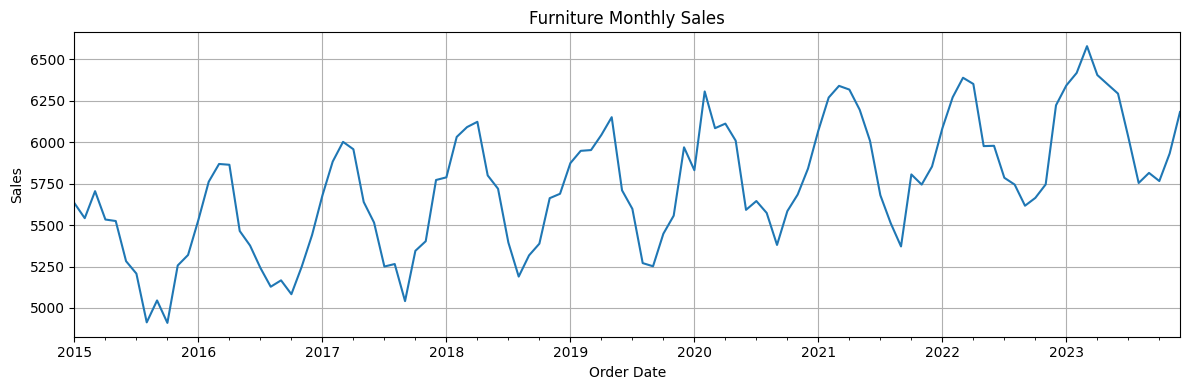

In [ ]:
run_arima_forecast("Furniture")
run_arima_forecast("Office Supplies")
